In [1]:
from dependencies import *
import os
import igraph
from scipy.sparse import csr_matrix
from collections import Counter
import implicit
import networkx as nx

## Load tweets

In [2]:
data = load_tweets()

## Create graph

In [3]:
def create_graph(data, user='user', retweeted_user='in_reply_to_screen_name'):
    graph = {}
    
    for i in data.index:
        if data.loc[i][retweeted_user] != None:
            if data.loc[i][user]['screen_name'] not in list(graph.keys()):
                graph[data.loc[i][user]['screen_name']] = [data.loc[i][retweeted_user]]
            elif data.loc[i][retweeted_user] not in graph[data.loc[i][user]['screen_name']]:
                graph[data.loc[i][user]['screen_name']].append(data.loc[i][retweeted_user])
            else:
                continue
    return graph

In [4]:
graph = create_graph(data)
g = igraph.Graph()
g.add_vertices(list(set(list(graph.keys()) + list([a for value in graph.values() for a in value]))))
g.add_edges([(key, value) for key in graph.keys() for value in graph[key]])

print('Nodes: {}\nEdges: {}'.format(len(g.vs), len(g.es)))

Nodes: 11074
Edges: 7678


## Split trian/test

In [5]:
import random
random.seed(1)

p = 0.2
N = len(g.es)
all_idxs = range(N)
test_ids = np.random.choice(a = all_idxs, size = int(p*N), replace=False)
aux = g.copy()
aux.delete_vertices(test_ids)

print('Nodes: {}\nEdges: {}'.format(len(aux.vs), len(aux.es)))

Nodes: 9539
Edges: 5831


## Make recomentadions

In [6]:
def recomendations(graph):
    
    recommendations = set()
    for n1 in graph.vs:
        
        nodes_at_most_distant_1 = set(graph.neighborhood(vertices = n1, order = 1))
        nodes_at_most_distant_2 = set(graph.neighborhood(vertices = n1, order = 2))
        only_nodes_at_distance_2 = nodes_at_most_distant_2 - nodes_at_most_distant_1
        
        if len(only_nodes_at_distance_2) > 0:
            for n2 in only_nodes_at_distance_2:
                recommendations.add((n1.index, n2))
            
    return recommendations

In [7]:
result = set()
trainset = set()
for idx, edge in enumerate(g.es):
    n1 = edge.source
    n2 = edge.target
    
    if idx in test_ids:
        result.add((n1, n2, 1))
    else:
        trainset.add((n1, n2, 1))

recommendations = recomendations(aux)
for r in recommendations:
    rec1 = r[0]
    rec2 = r[1]
    result.add((rec1,rec2,0))

# PageRank

In [9]:
topkppr = {}
topk = 1
for node in test_ids:
    pr = enumerate(g.personalized_pagerank(reset_vertices=node))
    out = sorted(pr, key=lambda tup: tup[1], reverse=True)[:topk]
    topkppr[node] = out[0][0]

ppr_df = pd.DataFrame({'node':list(topkppr.keys()), 'recommendation': list(topkppr.values())})
for i in ppr_df.index:
    if ppr_df.loc[i]['node'] == ppr_df.loc[i]['recommendation']:
        ppr_df = ppr_df.drop(i)

df_test = pd.DataFrame(list(result), columns=["n1","n2", "edge"])
l = []
for i in df_test.index:
    for j in ppr_df.index:
        if df_test.loc[i]['n1'] == ppr_df.loc[j]['node'] and df_test.loc[i]['n2'] == ppr_df.loc[j]['recommendation']:
            l.append(1)
        else:
            l.append(0)
            break

df_test['rating'] = l

right_predictions = len(df_test[df_test['rating']==df_test['edge']])
right_predictions/len(df_test)

0.9730786849430917

# Alternating Least Squares

In [10]:
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
M = g.get_adjacency().data
M = csr_matrix(M)

model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True,  iterations=5)
model.fit(M)

df_test = pd.DataFrame(list(result), columns=["n1","n2", "edge"])
all_predictions = []

for n1,n2, w in df_test.values:
    array_n1 = model.user_factors[n1,:]
    array_n2 = model.item_factors[n2,:]
    one_p = np.dot(array_n1, array_n2)
    all_predictions.append(one_p)


df_test["rating"] = all_predictions
df_test["rating"] = df_test["rating"].apply(lambda x: round(x))

right_predictions = len(df_test[df_test['rating']==df_test['edge']])
right_predictions/len(df_test)

0.9745234152013813

# Resulting plot

In [32]:
keys = [x[0] for x in result]
values = [x[1] for x in result]
plot = {}
for i in range(len(keys)):
    plot[str(keys[i])] = str(values[i])


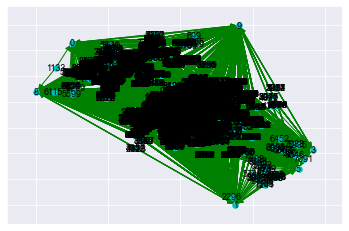

In [35]:
aux = nx.DiGraph(plot)
pos=nx.spring_layout(aux)
nx.draw_networkx(aux, pos, with_labels=True, node_size=30, node_color='c', font_size = 9, edge_color='g')